In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import chi2

In [8]:
# Load dataset
df = pd.read_csv("/Users/nidhipareddy/Desktop/uchicago/ML2/merged_compas_data_final.csv")

# Drop high-cardinality columns
df = df.drop(columns=['case_number', 'in_custody', 'out_custody', 'name'], errors='ignore')

# Drop cols w most missing vals 
missing_threshold = 0.95
df = df.loc[:, df.isnull().mean() < missing_threshold]

# Drow N/A rows 
df = df.dropna()

# 0,1 only (Y/N)
df = df[df['is_recid'] >= 0]

# Feature prep 
X = df.drop(columns=['person_id', 'is_recid'])  
y = df['is_recid']  # Binary target var

threshold = 100
high_card_cols = [col for col in X.columns if X[col].dtype == 'object' and X[col].nunique() > threshold]
X = X.drop(columns=high_card_cols)

categorical_columns = [col for col in X.columns if X[col].dtype == 'object']
numeric_columns = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]

# Train + test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_columns)
    ]
)

In [15]:
# Define pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', HistGradientBoostingClassifier(random_state=42))
])

# Fit model
pipeline.fit(X_train, y_train)

# Evaluate
y_pred = pipeline.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.893945565257666
Confusion Matrix:
 [[ 235960  135183]
 [  20524 1076513]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.64      0.75    371143
           1       0.89      0.98      0.93   1097037

    accuracy                           0.89   1468180
   macro avg       0.90      0.81      0.84   1468180
weighted avg       0.90      0.89      0.89   1468180



AUC Score: 0.9547


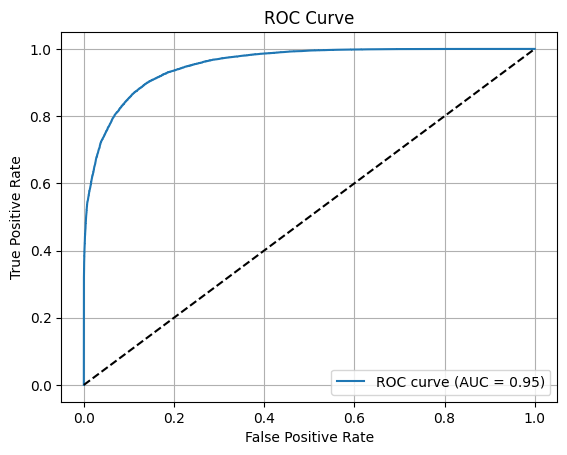

In [23]:
# Get predicted probabilities for class 1
y_proba = pipeline.predict_proba(X_test)[:, 1]

# ROC & AUC
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

print(f"AUC Score: {auc_score:.4f}")

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [24]:
X_cat_encoded = preprocessor.named_transformers_['cat'].transform(X[categorical_columns])
chi2_scores, p_vals = chi2(X_cat_encoded, y)

feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns)

chi2_df = pd.DataFrame({'Feature': feature_names, 'Chi2': chi2_scores, 'p-value': p_vals})
chi2_df = chi2_df.sort_values(by='Chi2', ascending=False)
print(chi2_df.head(10))

                                               Feature           Chi2  p-value
124                           filing_agency_Sunrise PD  191205.414931      0.0
60                          filing_type_No Information   88914.919611      0.0
29                                       race_Hispanic   74593.519376      0.0
20                              marital_status_Married   49681.286565      0.0
28                                      race_Caucasian   44737.703752      0.0
102                   filing_agency_Fort Lauderdale PD   28610.189851      0.0
81   filing_agency_Broward Sheriff Office/Oakland Park   26950.549858      0.0
41                                c_charge_degree_(M1)   26573.565410      0.0
30                                race_Native American   26070.604949      0.0
36                                c_charge_degree_(F2)   26053.827354      0.0


In [26]:
X_numeric_df = X[numeric_columns].copy()
X_numeric_df['target'] = y

correlations = X_numeric_df.corr(method='pearson')['target'].drop('target').sort_values(key=np.abs, ascending=False)
print("Top Pearson Correlations with target:\n", correlations)

Top Pearson Correlations with target:
 age                    -0.226584
juv_other_count         0.091551
juv_fel_count           0.066096
juv_misd_count          0.040021
prison_duration_days   -0.013336
priors_count           -0.000064
Name: target, dtype: float64


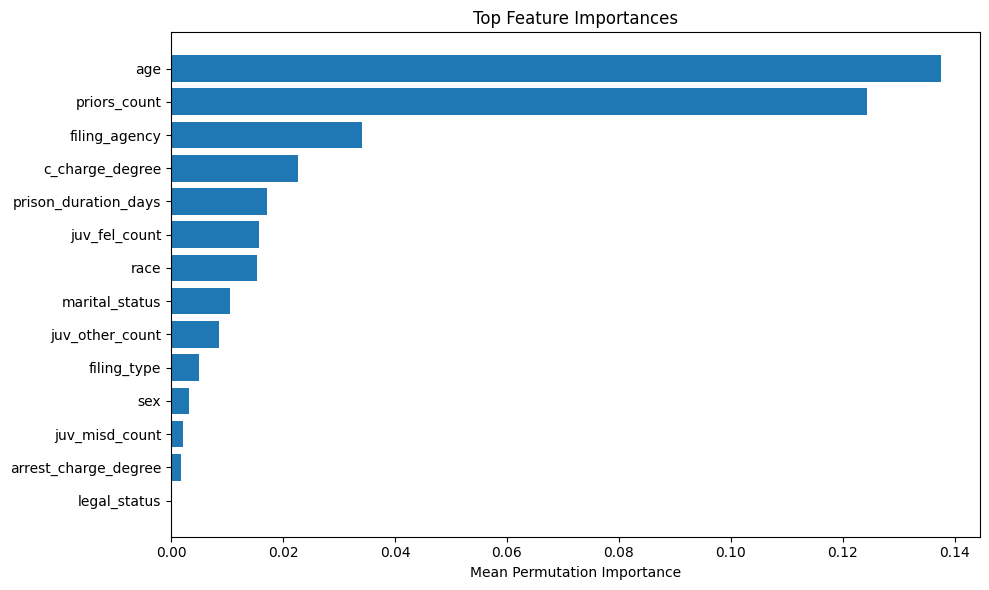

In [22]:
# Sample the test set 
X_sample = X_test.sample(n=10000, random_state=42)
y_sample = y_test.loc[X_sample.index]

# Run permutation importance
result = permutation_importance(pipeline, X_sample, y_sample, n_repeats=3, random_state=42, n_jobs=-1)

# Extract top features 
top_n = min(20, len(result.importances_mean))
sorted_idx = result.importances_mean.argsort()[::-1]

plt.figure(figsize=(10, 6))
plt.barh(range(top_n), result.importances_mean[sorted_idx[:top_n]][::-1])
plt.yticks(range(top_n), np.array(X_sample.columns)[sorted_idx[:top_n]][::-1])
plt.xlabel("Mean Permutation Importance")
plt.title("Top Feature Importances")
plt.tight_layout()
plt.show()
